# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)

from ema_workbench import Samplers

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

In [2]:
def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25,
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))

    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt

    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

#### 1. Sensitivity analysis
Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment

In [3]:
# Instantiate the model
model = Model('lake', function=pred_prey)

# Specify uncertainties  # Dit is dus een vijf dimensionele space van uncertainties. Met voor elke dimensie een min en max waarde zeg maar.
model.uncertainties = [RealParameter('prey_birth_rate',0.015,0.035), RealParameter('predation_rate',0.0005,0.003),
                       RealParameter('predator_efficiency',0.001,0.004), RealParameter('predator_loss_rate',0.04,0.08)]

# Specify outcomes
model.outcomes = [TimeSeriesOutcome('predators')]


#Waarom is dit Time Series en geen Scalar?

In [4]:
from ema_workbench import SequentialEvaluator
from ema_workbench import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000, uncertainty_sampling=Samplers.LHS)

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
100%|█████████████████████████████████████| 1000/1000 [00:09<00:00, 102.11it/s]
[MainProcess/INFO] experiments finished


In [5]:
#experiments2, outcomes2 = perform_experiments(model,1000, uncertainty_sampling=Samplers.LHS)

Verschil tussen twee hierboven? Is hetzelfde.

In [6]:
experiments

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.002373,0.001050,0.065842,0.028333,0,None,lake
1,0.002179,0.003024,0.061457,0.030950,1,None,lake
2,0.000605,0.002857,0.046647,0.029815,2,None,lake
3,0.000773,0.002286,0.041864,0.026550,3,None,lake
4,0.000877,0.003146,0.048130,0.026972,4,None,lake
...,...,...,...,...,...,...,...
995,0.001928,0.003823,0.058421,0.034773,995,None,lake
996,0.000635,0.002113,0.056952,0.033952,996,None,lake
997,0.002388,0.003529,0.072100,0.026177,997,None,lake
998,0.001283,0.002420,0.076848,0.030780,998,None,lake


In [7]:
outcomes['predators']

array([[[20.        , 19.93330657, 19.86558434, ...,  5.42716945,
          5.4193976 ,  5.41195154]],

       [[20.        , 20.44871924, 20.905067  , ..., 42.13385865,
         41.76901633, 41.40307331]],

       [[20.        , 20.48097858, 20.97676478, ...,  3.33082804,
          3.31285506,  3.29512334]],

       ...,

       [[20.        , 20.52164829, 21.05201613, ..., 46.45085202,
         46.86510032, 47.2562832 ]],

       [[20.        , 20.22077172, 20.44476352, ...,  8.94427253,
          8.91777559,  8.8920565 ]],

       [[20.        , 20.12674966, 20.25103396, ...,  2.19594287,
          2.18105637,  2.16629447]]])

In [8]:
outcomes['predators'].shape

(1000, 1, 1461)

In [9]:
outcomes['predators'][:,0, -1]

array([5.41195154e+00, 4.14030733e+01, 3.29512334e+00, 5.56406080e+00,
       2.18802018e+00, 1.29759629e+01, 8.63083534e-02, 6.88347733e+00,
       2.07123896e+01, 1.19492843e+01, 2.42980644e+01, 3.19104332e+00,
       2.17808124e+01, 1.67455603e+00, 5.07772206e+01, 3.89380557e+01,
       5.92711854e-01, 4.10614298e-01, 2.65939875e+00, 1.97219626e+00,
       3.15087136e+01, 9.59192763e+00, 2.00682505e+01, 4.03740138e+01,
       4.70760586e+00, 8.61076713e+00, 1.01038670e+02, 1.58721434e+01,
       3.21439111e-01, 7.27133811e+00, 6.74764771e-01, 5.20159555e+00,
       1.44379892e+01, 4.32909203e+01, 5.51942001e+00, 4.52667573e+01,
       2.71892218e+01, 7.67044797e+01, 2.03582443e+01, 9.25258279e+01,
       1.48466262e+01, 5.33281791e-01, 1.74976758e+00, 5.25334011e+00,
       5.96183560e+00, 2.21325600e+01, 1.40714999e+00, 1.19769516e+01,
       3.48848933e+01, 2.52691105e+00, 3.58852952e+01, 1.02833725e+01,
       1.27560747e+01, 1.23209210e+01, 4.85001642e+01, 2.48064556e+00,
      

In [10]:
final_values_prey = outcomes['predators'][:,0, -1]

In [11]:
len(final_values_prey)

1000

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [13]:
data_x = experiments.iloc[:,0:4].values
data_x

array([[0.00237308, 0.00105006, 0.06584189, 0.02833305],
       [0.00217858, 0.00302402, 0.06145704, 0.03095045],
       [0.00060461, 0.00285685, 0.04664656, 0.02981537],
       ...,
       [0.00238849, 0.00352859, 0.07210007, 0.02617669],
       [0.00128296, 0.00242004, 0.07684755, 0.03078   ],
       [0.00290019, 0.0013276 , 0.04102985, 0.01885874]])

In [14]:
data_x_exog = sm.add_constant(data_x, prepend=False)
data_x_exog

array([[2.37308115e-03, 1.05006402e-03, 6.58418867e-02, 2.83330544e-02,
        1.00000000e+00],
       [2.17857877e-03, 3.02401766e-03, 6.14570350e-02, 3.09504546e-02,
        1.00000000e+00],
       [6.04613915e-04, 2.85684543e-03, 4.66465564e-02, 2.98153671e-02,
        1.00000000e+00],
       ...,
       [2.38848840e-03, 3.52859452e-03, 7.21000691e-02, 2.61766882e-02,
        1.00000000e+00],
       [1.28296348e-03, 2.42003781e-03, 7.68475461e-02, 3.07800024e-02,
        1.00000000e+00],
       [2.90018640e-03, 1.32759557e-03, 4.10298466e-02, 1.88587400e-02,
        1.00000000e+00]])

In [15]:
data_y = final_values_prey
data_y

array([5.41195154e+00, 4.14030733e+01, 3.29512334e+00, 5.56406080e+00,
       2.18802018e+00, 1.29759629e+01, 8.63083534e-02, 6.88347733e+00,
       2.07123896e+01, 1.19492843e+01, 2.42980644e+01, 3.19104332e+00,
       2.17808124e+01, 1.67455603e+00, 5.07772206e+01, 3.89380557e+01,
       5.92711854e-01, 4.10614298e-01, 2.65939875e+00, 1.97219626e+00,
       3.15087136e+01, 9.59192763e+00, 2.00682505e+01, 4.03740138e+01,
       4.70760586e+00, 8.61076713e+00, 1.01038670e+02, 1.58721434e+01,
       3.21439111e-01, 7.27133811e+00, 6.74764771e-01, 5.20159555e+00,
       1.44379892e+01, 4.32909203e+01, 5.51942001e+00, 4.52667573e+01,
       2.71892218e+01, 7.67044797e+01, 2.03582443e+01, 9.25258279e+01,
       1.48466262e+01, 5.33281791e-01, 1.74976758e+00, 5.25334011e+00,
       5.96183560e+00, 2.21325600e+01, 1.40714999e+00, 1.19769516e+01,
       3.48848933e+01, 2.52691105e+00, 3.58852952e+01, 1.02833725e+01,
       1.27560747e+01, 1.23209210e+01, 4.85001642e+01, 2.48064556e+00,
      

In [16]:
mod = sm.OLS(data_y, data_x_exog)

In [17]:
res = mod.fit()

In [18]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     38.08
Date:                Wed, 17 May 2023   Prob (F-statistic):           1.13e-29
Time:                        02:06:36   Log-Likelihood:                -4500.1
No. Observations:                1000   AIC:                             9010.
Df Residuals:                     995   BIC:                             9035.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.029e+04    957.645    -10.746      0.0

Kan dus gewoon direct vanuit dataframe, de onafhankelijke variabele!

In [19]:
data_x_exog2 = sm.add_constant(experiments.iloc[:,0:4], prepend=False)

In [20]:
mod2= sm.OLS(data_y, data_x_exog2)

In [21]:
res2 = mod2.fit()

In [22]:
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     38.08
Date:                Wed, 17 May 2023   Prob (F-statistic):           1.13e-29
Time:                        02:06:36   Log-Likelihood:                -4500.1
No. Observations:                1000   AIC:                             9010.
Df Residuals:                     995   BIC:                             9035.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
predation_rate      -1.029e+04    

Subvraag 2

In [23]:
outcomes['predators']

array([[[20.        , 19.93330657, 19.86558434, ...,  5.42716945,
          5.4193976 ,  5.41195154]],

       [[20.        , 20.44871924, 20.905067  , ..., 42.13385865,
         41.76901633, 41.40307331]],

       [[20.        , 20.48097858, 20.97676478, ...,  3.33082804,
          3.31285506,  3.29512334]],

       ...,

       [[20.        , 20.52164829, 21.05201613, ..., 46.45085202,
         46.86510032, 47.2562832 ]],

       [[20.        , 20.22077172, 20.44476352, ...,  8.94427253,
          8.91777559,  8.8920565 ]],

       [[20.        , 20.12674966, 20.25103396, ...,  2.19594287,
          2.18105637,  2.16629447]]])

In [24]:
outcomes['predators'][:,0]

array([[20.        , 19.93330657, 19.86558434, ...,  5.42716945,
         5.4193976 ,  5.41195154],
       [20.        , 20.44871924, 20.905067  , ..., 42.13385865,
        41.76901633, 41.40307331],
       [20.        , 20.48097858, 20.97676478, ...,  3.33082804,
         3.31285506,  3.29512334],
       ...,
       [20.        , 20.52164829, 21.05201613, ..., 46.45085202,
        46.86510032, 47.2562832 ],
       [20.        , 20.22077172, 20.44476352, ...,  8.94427253,
         8.91777559,  8.8920565 ],
       [20.        , 20.12674966, 20.25103396, ...,  2.19594287,
         2.18105637,  2.16629447]])

In [25]:
list_y_mean = []
for i in outcomes['predators'][:,0,:]:
    #print(i.mean())
    list_y_mean.append(i.mean())
#list_y_mean

In [26]:
mod3= sm.OLS(list_y_mean, data_x_exog2)
res3 = mod3.fit()
print(res3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     922.2
Date:                Wed, 17 May 2023   Prob (F-statistic):               0.00
Time:                        02:06:36   Log-Likelihood:                -3134.7
No. Observations:                1000   AIC:                             6279.
Df Residuals:                     995   BIC:                             6304.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
predation_rate       -1.36e+04    

Subvraag 3, zelfde verhaal.

In [27]:
list_y_std = []
for i in outcomes['predators'][:,0,:]:
    #print(i.mean())
    list_y_std.append(i.std())
#list_y_std

#### 2. SOBOL
Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function.

*hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply use slicing to get the results for N=50 and N=250.

In [29]:
from ema_workbench import MultiprocessingEvaluator, ema_logging, perform_experiments
from SALib.analyze import sobol
from ema_workbench import Samplers
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

with SequentialEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, uncertainty_sampling=Samplers.SOBOL)

experiments, outcomes = sa_results

C:\Users\thoma\Anaconda3\envs\model_based_decision_making\Lib\site-packages\scipy\stats\_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
100%|████████████████████████████████████| 10000/10000 [01:46<00:00, 93.54it/s]
[MainProcess/INFO] experiments finished


ValueError: could not broadcast input array from shape (1000,1,1461) into shape (1461000,)

In [30]:
problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(problem, outcomes["predators"][:,0, -1], calc_second_order=True, print_to_console=False)

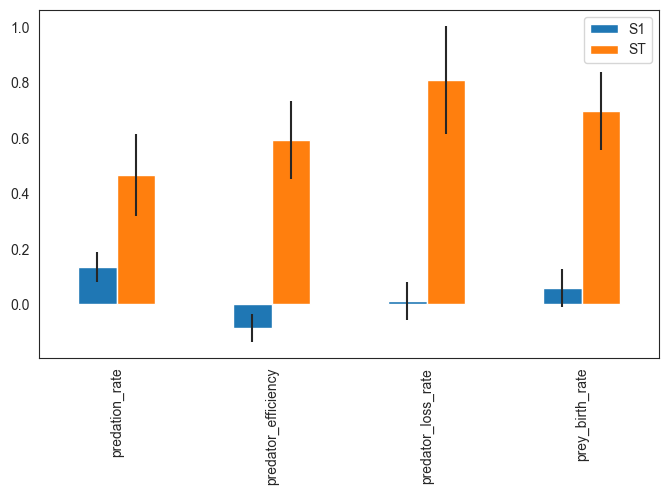

In [33]:
import pandas as pd
import seaborn as sns

scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)
plt.show()

Dit is nu alleen gedaan voor alleen de eerste indicator (bullet point) in opdracht 1 lineare regressie, de final waardes van prey over de verschillende experimenten.

#### 3. Extra trees
Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [43]:
x = experiments.iloc[:,0:4]
y = outcomes["predators"][:,0, -1]

In [45]:
feature_scoring.get_ex_feature_scores(x, y, mode=RuleInductionType.REGRESSION, nr_trees=100, max_features=0.6, max_depth=None, min_samples_split=2, min_samples_leaf=None, min_weight_fraction_leaf=0, max_leaf_nodes=None, bootstrap=True, oob_score=True, random_state=None)


(                            1
 0                            
 predation_rate       0.316357
 predator_loss_rate   0.269644
 prey_birth_rate      0.241128
 predator_efficiency  0.172870,
 ExtraTreesRegressor(bootstrap=True, max_features=0.6, min_samples_leaf=3,
                     min_weight_fraction_leaf=0, oob_score=True))